# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [20]:
# can comment out after executing
# !unzip processed-celeba-small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    images = ImageFolder(root=data_dir, transform=transform)
    
    return DataLoader(dataset=images, batch_size=batch_size, shuffle=True)


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 64 # maybe we need to change it later
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

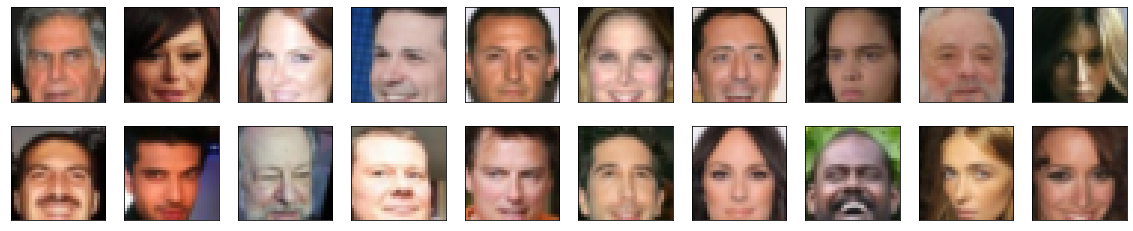

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.8980)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        out = out.view(-1, self.conv_dim*4*4*4)
        
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def conv_T(input_channel, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    module_list = []
    
    if batch_norm == True: 
        conv_layer =  nn.ConvTranspose2d(input_channel, out_channels, kernel_size=kernel_size, 
                                            stride=stride, padding=padding, bias=False)
        module_list.append(conv_layer)
        batch_normalization = nn.BatchNorm2d(out_channels)    
        module_list.append(batch_normalization)
        
    elif batch_norm == False:
        conv_layer = nn.ConvTranspose2d(input_channel, out_channels, kernel_size=kernel_size, 
                                           stride=stride, padding=padding, bias=True)
        module_list.append(conv_layer)
    
    
    return nn.Sequential(*module_list)


In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.z_size = z_size
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, 4*4*self.conv_dim*4)
        self.conv_t1 = conv_T(self.conv_dim*4, self.conv_dim*2)
        self.conv_t2 = conv_T(self.conv_dim*2, self.conv_dim)
        self.conv_t3 = conv_T(self.conv_dim, 3, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, heigh, width)
        
        out = F.relu(self.conv_t1(out))
        out = F.relu(self.conv_t2(out))
        out = torch.tanh(self.conv_t3(out))
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 200

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=200, out_features=2048, bias=True)
  (conv_t1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_t2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50, smooth=False):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images

            # Compute the discriminator losses on real images 
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            # 1. Train with fake images and flipped labels
            g_optimizer.zero_grad()

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [24]:
# set number of epochs 
n_epochs = 5

smooths=[False, True]
lrs = [0.0001, 0.0002, 0.001]

d_conv_dim = 32
g_conv_dim = 32
z_size = 200

batch_size = 64

for smooth in smooths:
    for lr in lrs:
        print('================================================')
        print("smooth:", smooth)
        print("lr:", lr)
        print('')
        
        celeba_train_loader = get_dataloader(batch_size, 32)
        D, G = build_network(d_conv_dim, g_conv_dim, z_size)
        
        d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
        g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

        """
        DON'T MODIFY ANYTHING IN THIS CELL
        """
        # call training function
        losses = train(D, G, n_epochs, 50, smooth)

smooth: False
lr: 0.0001

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=200, out_features=2048, bias=True)
  (conv_t1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_t2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2

Epoch [    5/    5] | d_loss: 0.7535 | g_loss: 1.4509
Epoch [    5/    5] | d_loss: 1.0846 | g_loss: 1.0438
Epoch [    5/    5] | d_loss: 0.6686 | g_loss: 1.4444
Epoch [    5/    5] | d_loss: 0.7029 | g_loss: 1.3610
Epoch [    5/    5] | d_loss: 0.9359 | g_loss: 1.1752
Epoch [    5/    5] | d_loss: 1.1421 | g_loss: 0.6574
Epoch [    5/    5] | d_loss: 0.7293 | g_loss: 1.8005
Epoch [    5/    5] | d_loss: 0.7145 | g_loss: 1.5618
Epoch [    5/    5] | d_loss: 0.6190 | g_loss: 1.3311
Epoch [    5/    5] | d_loss: 0.7816 | g_loss: 1.2283
Epoch [    5/    5] | d_loss: 0.7305 | g_loss: 1.7038
Epoch [    5/    5] | d_loss: 0.9170 | g_loss: 1.7840
Epoch [    5/    5] | d_loss: 0.5886 | g_loss: 2.2308
Epoch [    5/    5] | d_loss: 1.2144 | g_loss: 0.8660
Epoch [    5/    5] | d_loss: 0.7057 | g_loss: 1.2003
Epoch [    5/    5] | d_loss: 0.6731 | g_loss: 1.2156
Epoch [    5/    5] | d_loss: 0.8986 | g_loss: 1.1028
smooth: False
lr: 0.0002

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3,

Epoch [    4/    5] | d_loss: 0.9040 | g_loss: 1.3535
Epoch [    4/    5] | d_loss: 0.5073 | g_loss: 1.8328
Epoch [    4/    5] | d_loss: 0.8551 | g_loss: 1.8543
Epoch [    4/    5] | d_loss: 0.7946 | g_loss: 1.5298
Epoch [    4/    5] | d_loss: 0.8743 | g_loss: 1.7250
Epoch [    5/    5] | d_loss: 0.9575 | g_loss: 1.9207
Epoch [    5/    5] | d_loss: 0.8861 | g_loss: 1.4147
Epoch [    5/    5] | d_loss: 0.7273 | g_loss: 1.2987
Epoch [    5/    5] | d_loss: 1.1571 | g_loss: 1.4639
Epoch [    5/    5] | d_loss: 0.7131 | g_loss: 1.3764
Epoch [    5/    5] | d_loss: 0.6052 | g_loss: 1.3042
Epoch [    5/    5] | d_loss: 0.8974 | g_loss: 1.9792
Epoch [    5/    5] | d_loss: 0.5479 | g_loss: 2.4241
Epoch [    5/    5] | d_loss: 0.5816 | g_loss: 2.7650
Epoch [    5/    5] | d_loss: 0.6906 | g_loss: 1.4305
Epoch [    5/    5] | d_loss: 0.8681 | g_loss: 1.2410
Epoch [    5/    5] | d_loss: 0.7079 | g_loss: 1.9938
Epoch [    5/    5] | d_loss: 0.8381 | g_loss: 1.7401
Epoch [    5/    5] | d_loss

Epoch [    4/    5] | d_loss: 0.8712 | g_loss: 1.5898
Epoch [    4/    5] | d_loss: 0.9116 | g_loss: 1.1273
Epoch [    4/    5] | d_loss: 1.0474 | g_loss: 0.9636
Epoch [    4/    5] | d_loss: 1.2720 | g_loss: 3.2466
Epoch [    4/    5] | d_loss: 1.1594 | g_loss: 1.2853
Epoch [    4/    5] | d_loss: 1.0764 | g_loss: 1.4052
Epoch [    4/    5] | d_loss: 2.2091 | g_loss: 0.6140
Epoch [    4/    5] | d_loss: 0.8864 | g_loss: 1.9942
Epoch [    4/    5] | d_loss: 0.9653 | g_loss: 1.5973
Epoch [    4/    5] | d_loss: 0.9524 | g_loss: 1.5373
Epoch [    4/    5] | d_loss: 1.2726 | g_loss: 0.5778
Epoch [    4/    5] | d_loss: 0.9865 | g_loss: 1.2546
Epoch [    4/    5] | d_loss: 0.8817 | g_loss: 2.3092
Epoch [    4/    5] | d_loss: 1.1320 | g_loss: 2.2915
Epoch [    4/    5] | d_loss: 0.9490 | g_loss: 1.6009
Epoch [    4/    5] | d_loss: 0.9363 | g_loss: 1.1097
Epoch [    4/    5] | d_loss: 0.8930 | g_loss: 1.2337
Epoch [    4/    5] | d_loss: 0.8672 | g_loss: 2.4820
Epoch [    4/    5] | d_loss

Epoch [    3/    5] | d_loss: 1.1879 | g_loss: 1.2025
Epoch [    3/    5] | d_loss: 0.8893 | g_loss: 1.4956
Epoch [    3/    5] | d_loss: 0.8854 | g_loss: 1.4498
Epoch [    3/    5] | d_loss: 1.0387 | g_loss: 1.5378
Epoch [    3/    5] | d_loss: 0.7197 | g_loss: 2.6762
Epoch [    3/    5] | d_loss: 1.0549 | g_loss: 0.8823
Epoch [    3/    5] | d_loss: 0.9221 | g_loss: 1.3586
Epoch [    3/    5] | d_loss: 0.9438 | g_loss: 1.1172
Epoch [    3/    5] | d_loss: 1.3717 | g_loss: 0.8335
Epoch [    3/    5] | d_loss: 1.0206 | g_loss: 1.5266
Epoch [    4/    5] | d_loss: 0.9641 | g_loss: 1.9221
Epoch [    4/    5] | d_loss: 0.8751 | g_loss: 1.5675
Epoch [    4/    5] | d_loss: 0.8738 | g_loss: 1.2486
Epoch [    4/    5] | d_loss: 1.7528 | g_loss: 1.8764
Epoch [    4/    5] | d_loss: 0.8908 | g_loss: 1.3081
Epoch [    4/    5] | d_loss: 1.1078 | g_loss: 1.6316
Epoch [    4/    5] | d_loss: 0.9773 | g_loss: 1.3473
Epoch [    4/    5] | d_loss: 0.9698 | g_loss: 1.7262
Epoch [    4/    5] | d_loss

Epoch [    3/    5] | d_loss: 0.9451 | g_loss: 1.5538
Epoch [    3/    5] | d_loss: 0.9546 | g_loss: 1.0344
Epoch [    3/    5] | d_loss: 1.0970 | g_loss: 1.3790
Epoch [    3/    5] | d_loss: 0.7667 | g_loss: 1.5709
Epoch [    3/    5] | d_loss: 0.9544 | g_loss: 2.1449
Epoch [    3/    5] | d_loss: 0.8566 | g_loss: 1.6241
Epoch [    3/    5] | d_loss: 1.0361 | g_loss: 1.3096
Epoch [    3/    5] | d_loss: 1.1553 | g_loss: 1.5816
Epoch [    3/    5] | d_loss: 1.1041 | g_loss: 1.7471
Epoch [    3/    5] | d_loss: 0.8858 | g_loss: 0.9628
Epoch [    3/    5] | d_loss: 0.8508 | g_loss: 1.5158
Epoch [    3/    5] | d_loss: 1.0823 | g_loss: 1.0004
Epoch [    3/    5] | d_loss: 0.8467 | g_loss: 1.7372
Epoch [    3/    5] | d_loss: 1.3358 | g_loss: 1.8658
Epoch [    3/    5] | d_loss: 1.1828 | g_loss: 1.4842
Epoch [    3/    5] | d_loss: 0.9436 | g_loss: 1.3215
Epoch [    3/    5] | d_loss: 0.9040 | g_loss: 1.8394
Epoch [    3/    5] | d_loss: 0.9727 | g_loss: 0.6797
Epoch [    3/    5] | d_loss

Epoch [    2/    5] | d_loss: 1.1278 | g_loss: 1.4021
Epoch [    2/    5] | d_loss: 1.1418 | g_loss: 1.7880
Epoch [    2/    5] | d_loss: 1.0280 | g_loss: 2.2647
Epoch [    2/    5] | d_loss: 1.1908 | g_loss: 1.5009
Epoch [    2/    5] | d_loss: 1.1263 | g_loss: 1.5769
Epoch [    2/    5] | d_loss: 1.1755 | g_loss: 1.0865
Epoch [    2/    5] | d_loss: 0.9874 | g_loss: 1.5656
Epoch [    2/    5] | d_loss: 1.1560 | g_loss: 1.6775
Epoch [    2/    5] | d_loss: 1.3695 | g_loss: 1.2043
Epoch [    2/    5] | d_loss: 1.0602 | g_loss: 1.8459
Epoch [    2/    5] | d_loss: 0.9706 | g_loss: 1.8483
Epoch [    2/    5] | d_loss: 1.0261 | g_loss: 1.1746
Epoch [    2/    5] | d_loss: 1.2698 | g_loss: 2.0554
Epoch [    2/    5] | d_loss: 1.2086 | g_loss: 1.3109
Epoch [    2/    5] | d_loss: 1.5813 | g_loss: 1.9459
Epoch [    3/    5] | d_loss: 1.1319 | g_loss: 1.6055
Epoch [    3/    5] | d_loss: 1.1441 | g_loss: 1.3166
Epoch [    3/    5] | d_loss: 1.1789 | g_loss: 1.4841
Epoch [    3/    5] | d_loss

### First observations

After the first check of the smooths and lr influence on the results, we can see, that learning rate 0.002 in combination with smooth is FALSE allows to show the best result.


Epoch [    5/    5] | d_loss: 0.8371 | g_loss: 0.8350

Anyway with smoothing all results were very close.

In [25]:
# set number of epochs 
n_epochs = 5

smooth=False
lr = 0.0002

d_conv_dims = 32
g_conv_dims = 32
z_sizes = [100,500,1000]

batch_sizes = [32,128,512]

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
   
for z_size in z_sizes:
    for batch_size in batch_sizes:
        print('================================================')
        print("z_size:", z_size)
        print("batch_size:", batch_size)
        print('')

        celeba_train_loader = get_dataloader(batch_size, 32)
        D, G = build_network(d_conv_dim, g_conv_dim, z_size)

        """
        DON'T MODIFY ANYTHING IN THIS CELL
        """
        # call training function
        losses = train(D, G, n_epochs, 50, smooth)

z_size: 100
batch_size: 32

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (conv_t1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_t2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=

Epoch [    3/    5] | d_loss: 1.2177 | g_loss: 0.9223
Epoch [    3/    5] | d_loss: 1.1827 | g_loss: 0.8644
Epoch [    3/    5] | d_loss: 1.1523 | g_loss: 0.7698
Epoch [    3/    5] | d_loss: 1.2473 | g_loss: 0.8455
Epoch [    3/    5] | d_loss: 1.1240 | g_loss: 0.8627
Epoch [    3/    5] | d_loss: 1.1421 | g_loss: 0.8426
Epoch [    3/    5] | d_loss: 1.1448 | g_loss: 0.7959
Epoch [    3/    5] | d_loss: 1.1810 | g_loss: 0.8423
Epoch [    3/    5] | d_loss: 1.0820 | g_loss: 0.9210
Epoch [    3/    5] | d_loss: 1.2890 | g_loss: 0.8794
Epoch [    3/    5] | d_loss: 1.2312 | g_loss: 0.8503
Epoch [    3/    5] | d_loss: 1.0991 | g_loss: 0.9015
Epoch [    3/    5] | d_loss: 1.1360 | g_loss: 0.9098
Epoch [    3/    5] | d_loss: 1.1464 | g_loss: 0.7996
Epoch [    3/    5] | d_loss: 1.1858 | g_loss: 0.8863
Epoch [    3/    5] | d_loss: 1.1967 | g_loss: 0.8834
Epoch [    3/    5] | d_loss: 1.0666 | g_loss: 0.9051
Epoch [    3/    5] | d_loss: 1.1292 | g_loss: 0.9095
Epoch [    3/    5] | d_loss

Epoch [    5/    5] | d_loss: 1.1818 | g_loss: 0.7945
Epoch [    5/    5] | d_loss: 1.2910 | g_loss: 0.7731
Epoch [    5/    5] | d_loss: 1.2448 | g_loss: 0.9196
Epoch [    5/    5] | d_loss: 1.1280 | g_loss: 0.8091
Epoch [    5/    5] | d_loss: 1.2010 | g_loss: 0.8698
z_size: 100
batch_size: 128

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (conv_t1): Sequential(
    

Epoch [    1/    5] | d_loss: 1.6037 | g_loss: 0.5403
Epoch [    1/    5] | d_loss: 1.5197 | g_loss: 0.5044
Epoch [    1/    5] | d_loss: 1.6513 | g_loss: 0.4882
Epoch [    1/    5] | d_loss: 1.6354 | g_loss: 0.5132
Epoch [    1/    5] | d_loss: 1.6410 | g_loss: 0.5197
Epoch [    1/    5] | d_loss: 1.5440 | g_loss: 0.4681
Epoch [    1/    5] | d_loss: 1.4845 | g_loss: 0.4896
Epoch [    1/    5] | d_loss: 1.5361 | g_loss: 0.5456
Epoch [    1/    5] | d_loss: 1.6106 | g_loss: 0.4530
Epoch [    1/    5] | d_loss: 1.5689 | g_loss: 0.5529
Epoch [    1/    5] | d_loss: 1.4922 | g_loss: 0.5149
Epoch [    1/    5] | d_loss: 1.5824 | g_loss: 0.4646
Epoch [    1/    5] | d_loss: 1.4279 | g_loss: 0.5280
Epoch [    1/    5] | d_loss: 1.5559 | g_loss: 0.5167
Epoch [    1/    5] | d_loss: 1.4729 | g_loss: 0.4850
Epoch [    1/    5] | d_loss: 1.4128 | g_loss: 0.5299
Epoch [    1/    5] | d_loss: 1.4443 | g_loss: 0.5333
Epoch [    1/    5] | d_loss: 1.4570 | g_loss: 0.5598
Epoch [    1/    5] | d_loss

Epoch [    3/    5] | d_loss: 1.5961 | g_loss: 0.5548
Epoch [    3/    5] | d_loss: 1.5226 | g_loss: 0.5213
Epoch [    3/    5] | d_loss: 1.4716 | g_loss: 0.5438
Epoch [    3/    5] | d_loss: 1.4693 | g_loss: 0.5394
Epoch [    3/    5] | d_loss: 1.5743 | g_loss: 0.5115
Epoch [    3/    5] | d_loss: 1.4675 | g_loss: 0.4690
Epoch [    3/    5] | d_loss: 1.4845 | g_loss: 0.4563
Epoch [    3/    5] | d_loss: 1.4782 | g_loss: 0.5610
Epoch [    3/    5] | d_loss: 1.4798 | g_loss: 0.5624
Epoch [    3/    5] | d_loss: 1.3956 | g_loss: 0.4645
Epoch [    3/    5] | d_loss: 1.5497 | g_loss: 0.5446
Epoch [    3/    5] | d_loss: 1.4064 | g_loss: 0.5195
Epoch [    3/    5] | d_loss: 1.6014 | g_loss: 0.6402
Epoch [    3/    5] | d_loss: 1.5573 | g_loss: 0.5595
Epoch [    3/    5] | d_loss: 1.4714 | g_loss: 0.5061
Epoch [    3/    5] | d_loss: 1.5157 | g_loss: 0.4844
Epoch [    3/    5] | d_loss: 1.6011 | g_loss: 0.5034
Epoch [    3/    5] | d_loss: 1.6377 | g_loss: 0.5188
Epoch [    4/    5] | d_loss

Epoch [    1/    5] | d_loss: 1.3154 | g_loss: 0.6867
Epoch [    1/    5] | d_loss: 1.3833 | g_loss: 0.6476
Epoch [    1/    5] | d_loss: 1.3457 | g_loss: 0.6307
Epoch [    1/    5] | d_loss: 1.3532 | g_loss: 0.6726
Epoch [    1/    5] | d_loss: 1.3206 | g_loss: 0.6710
Epoch [    1/    5] | d_loss: 1.3528 | g_loss: 0.6844
Epoch [    1/    5] | d_loss: 1.3562 | g_loss: 0.6950
Epoch [    1/    5] | d_loss: 1.3879 | g_loss: 0.7090
Epoch [    1/    5] | d_loss: 1.3265 | g_loss: 0.6554
Epoch [    1/    5] | d_loss: 1.3213 | g_loss: 0.6566
Epoch [    1/    5] | d_loss: 1.4129 | g_loss: 0.6471
Epoch [    1/    5] | d_loss: 1.3502 | g_loss: 0.6749
Epoch [    1/    5] | d_loss: 1.3725 | g_loss: 0.6319
Epoch [    1/    5] | d_loss: 1.3879 | g_loss: 0.6924
Epoch [    2/    5] | d_loss: 1.3012 | g_loss: 0.6770
Epoch [    2/    5] | d_loss: 1.3527 | g_loss: 0.6821
Epoch [    2/    5] | d_loss: 1.3602 | g_loss: 0.7396
Epoch [    2/    5] | d_loss: 1.3387 | g_loss: 0.6700
Epoch [    2/    5] | d_loss

Epoch [    1/    5] | d_loss: 1.4277 | g_loss: 0.7297
Epoch [    1/    5] | d_loss: 1.5100 | g_loss: 0.6487
Epoch [    1/    5] | d_loss: 1.4873 | g_loss: 0.6615
Epoch [    1/    5] | d_loss: 1.4690 | g_loss: 0.7301
Epoch [    1/    5] | d_loss: 1.6263 | g_loss: 0.6184
Epoch [    1/    5] | d_loss: 1.6458 | g_loss: 0.6490
Epoch [    1/    5] | d_loss: 1.4637 | g_loss: 0.5643
Epoch [    1/    5] | d_loss: 1.5647 | g_loss: 0.7111
Epoch [    1/    5] | d_loss: 1.5616 | g_loss: 0.6840
Epoch [    1/    5] | d_loss: 1.5332 | g_loss: 0.6539
Epoch [    1/    5] | d_loss: 1.5631 | g_loss: 0.7082
Epoch [    1/    5] | d_loss: 1.4596 | g_loss: 0.6133
Epoch [    1/    5] | d_loss: 1.5530 | g_loss: 0.6626
Epoch [    1/    5] | d_loss: 1.6464 | g_loss: 0.7562
Epoch [    1/    5] | d_loss: 1.4607 | g_loss: 0.6155
Epoch [    1/    5] | d_loss: 1.4853 | g_loss: 0.6366
Epoch [    1/    5] | d_loss: 1.5390 | g_loss: 0.6836
Epoch [    1/    5] | d_loss: 1.5272 | g_loss: 0.6893
Epoch [    1/    5] | d_loss

Epoch [    3/    5] | d_loss: 1.5576 | g_loss: 0.7299
Epoch [    3/    5] | d_loss: 1.5707 | g_loss: 0.5457
Epoch [    3/    5] | d_loss: 1.6035 | g_loss: 0.6398
Epoch [    3/    5] | d_loss: 1.5623 | g_loss: 0.5636
Epoch [    3/    5] | d_loss: 1.5894 | g_loss: 0.6131
Epoch [    3/    5] | d_loss: 1.6960 | g_loss: 0.6481
Epoch [    3/    5] | d_loss: 1.5455 | g_loss: 0.6732
Epoch [    3/    5] | d_loss: 1.5263 | g_loss: 0.6456
Epoch [    3/    5] | d_loss: 1.6676 | g_loss: 0.7131
Epoch [    4/    5] | d_loss: 1.5577 | g_loss: 0.6881
Epoch [    4/    5] | d_loss: 1.3573 | g_loss: 0.6330
Epoch [    4/    5] | d_loss: 1.5220 | g_loss: 0.6701
Epoch [    4/    5] | d_loss: 1.4627 | g_loss: 0.6156
Epoch [    4/    5] | d_loss: 1.6256 | g_loss: 0.6468
Epoch [    4/    5] | d_loss: 1.5392 | g_loss: 0.6204
Epoch [    4/    5] | d_loss: 1.5474 | g_loss: 0.6754
Epoch [    4/    5] | d_loss: 1.5145 | g_loss: 0.6656
Epoch [    4/    5] | d_loss: 1.4978 | g_loss: 0.7076
Epoch [    4/    5] | d_loss

Epoch [    1/    5] | d_loss: 1.3255 | g_loss: 0.7578
Epoch [    1/    5] | d_loss: 1.3777 | g_loss: 0.7510
Epoch [    1/    5] | d_loss: 1.3469 | g_loss: 0.7652
Epoch [    1/    5] | d_loss: 1.3475 | g_loss: 0.7725
Epoch [    1/    5] | d_loss: 1.3201 | g_loss: 0.7611
Epoch [    1/    5] | d_loss: 1.3635 | g_loss: 0.7755
Epoch [    1/    5] | d_loss: 1.3546 | g_loss: 0.7714
Epoch [    1/    5] | d_loss: 1.3412 | g_loss: 0.7684
Epoch [    1/    5] | d_loss: 1.3236 | g_loss: 0.8048
Epoch [    1/    5] | d_loss: 1.3243 | g_loss: 0.8301
Epoch [    2/    5] | d_loss: 1.3259 | g_loss: 0.7464
Epoch [    2/    5] | d_loss: 1.2843 | g_loss: 0.7760
Epoch [    2/    5] | d_loss: 1.3439 | g_loss: 0.7823
Epoch [    2/    5] | d_loss: 1.3214 | g_loss: 0.7767
Epoch [    2/    5] | d_loss: 1.3176 | g_loss: 0.7351
Epoch [    2/    5] | d_loss: 1.3129 | g_loss: 0.7301
Epoch [    2/    5] | d_loss: 1.2701 | g_loss: 0.8001
Epoch [    2/    5] | d_loss: 1.2873 | g_loss: 0.8082
Epoch [    2/    5] | d_loss

### Second research

ToDo write text here

In [32]:
# set number of epochs 
n_epochs = 1

smooth=False
lr = 0.0002

d_conv_dims = 32
g_conv_dims = 32
z_sizes = 100

batch_sizes = 32

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])


celeba_train_loader = get_dataloader(batch_size, 32)
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs, 50, smooth)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=1000, out_features=2048, bias=True)
  (conv_t1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_t2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

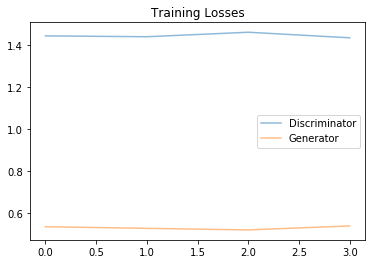

In [33]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [34]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [35]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

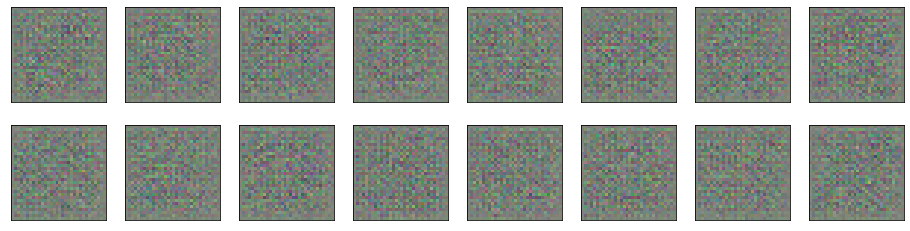

In [36]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.